# Recommender Task

Create a recommendation system based on the data in recsys_data.csv file.  

The goal is to recommend surveys with the highest completion probability to users (up to 3 surveys to each user). 

Data:

    ● user - the id of the user
    ● survey - the id of the survey
    ● status - whether the completion of the survey was successful or not (1 - successful, 0 - unsuccessful)
    ● date - the date of the survey completion attempt.
    
    Note: Surveys have a limited lifetime but exact lifetime information is not available
    (it can be 20 minutes, a week, a month, etc.). If you can create a recommendation system that pays more attention to newer surveys, it would be better. You can disregard this part if it makes the task harder for you.

---


In [ ]:
RANDOM_SEED = 1337

In [ ]:
from collections import defaultdict
from functools import partial
from multiprocessing import Pool
from typing import Iterable, Optional

import lightfm
import pandas as pd
import numpy as np

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.data import Dataset
from lightfm import cross_validation

from scipy.sparse import coo_matrix, csr_matrix
from tqdm.notebook import tqdm

## Read and preprocess data

In [ ]:
data = pd.read_csv('recsys_data.csv', parse_dates=['date'])

In [ ]:
data.head(15)

,user,survey,status,date
0,46120029,100000000,0,2020-06-25 16:08:06
1,61685181,100000001,0,2020-06-24 12:29:43
2,61900560,100000002,0,2020-06-24 20:35:37
3,26620554,100000003,0,2020-06-24 22:04:23
4,61973223,100000004,1,2020-06-25 15:15:02
5,61983168,100000005,1,2020-06-25 20:55:54
6,61985766,100000006,0,2020-06-25 20:30:24
7,61989825,100000007,0,2020-06-25 23:04:40
8,57974526,100000008,0,2020-06-24 17:02:11
9,61951965,100000009,1,2020-06-24 17:02:06


In [ ]:
data.status.value_counts()

0    1101197
1     212127
Name: status, dtype: int64

In [ ]:
min_date = min(data.date)
max_date = max(data.date)

min_date, max_date

(Timestamp('2020-06-24 08:16:25'), Timestamp('2020-06-28 04:16:08'))

How many users and items do we have here

In [ ]:
NUM_USERS = len(data.user.unique())
NUM_ITEMS = len(data.survey.unique())

NUM_USERS, NUM_ITEMS

(83126, 42445)

In [ ]:
user_survey_counts = data.groupby(by=['user', 'status'], as_index=False)['survey'].count()

In [ ]:
user_survey_counts

,user,status,survey
0,40881,0,5
1,43281,0,9
2,46035,0,1
3,47667,0,7
4,48396,0,7
...,...,...,...
127785,62078010,0,1
127786,62078025,0,1
127787,62078061,0,3
127788,62078103,0,1


<AxesSubplot:>

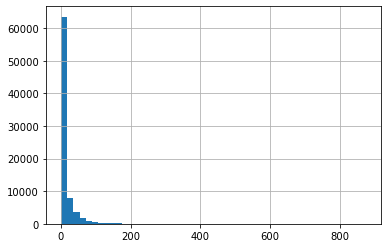

In [ ]:
user_survey_counts[user_survey_counts['status'] == 0]['survey'].hist(bins=50)

Who are these users with hundreds of incompleted surveys in less than 4 days? 0_o

<AxesSubplot:>

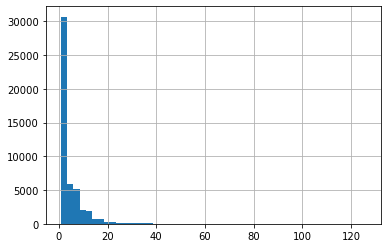

In [ ]:
user_survey_counts[user_survey_counts['status'] == 1]['survey'].hist(bins=50)

Check if there are any multiple entries of a same survey for any user

In [ ]:
assert data.shape == data.drop_duplicates().shape

Even though users haven't complete some of their surveys, we can still treat them as an implicit signal of interest. After all, they interacted with these items. It is also logical to have a higher weight for completed surveys

In [ ]:
SEEN_SURVEYS_WEIGHT = 1
COMPLETED_SURVEYS_WEIGHT = 3

data['rating'] = data['status'].apply(lambda r: COMPLETED_SURVEYS_WEIGHT if r > 0 else SEEN_SURVEYS_WEIGHT)

As we don't know the actual information of surveys' lifespan, we could approximate with their last completion attempts' dates

In [ ]:
data['date_doy'] = data['date'].apply(lambda pds: pds.day_of_year)
surveys_last_day = data.groupby(by=['survey'])['date_doy'].max()

We can also add some time decay term to weight user surveys interactions

In [ ]:
decay_speed = (max_date - min_date).days / 2

data['rating_decayed'] = data.apply(lambda row: row['rating'] * 0.5 ** ((max_date - row['date']).days / decay_speed), axis=1)

## Baseline

At the beginning, let's create a simple solution. It will also help us interpret performance of more complex approaches.

For example, for baseline we can recommend most frequently completed (previously unseen) surveys or the surveys with highest cumulative rating.

### Most completed surveys

In [ ]:
surveys_completeness = data.groupby(by=['survey'], as_index=False)['status'].agg(['count', 'sum'])

In [ ]:
surveys_completeness.reset_index(inplace=True)
surveys_completeness.columns = ['survey', 'taken', 'completed']

In [ ]:
completed_perc = np.percentile(surveys_completeness['completed'], 99)
taken_perc = np.percentile(surveys_completeness['taken'], 99)

In [ ]:
top_surveys_by_completion = surveys_completeness.sort_values(['completed'], ascending=False)
top_surveys_by_completion = top_surveys_by_completion[top_surveys_by_completion['completed'] > completed_perc]
top_surveys_by_completion

,survey,taken,completed
513,100000513,1573,1125
17,100000017,1845,1078
368,100000368,1427,990
136,100000136,5454,921
40,100000040,5806,894
...,...,...,...
2149,100002149,560,101
3121,100003121,123,101
1275,100001275,307,101
1089,100001089,416,101


### Top surveys with highest completion ratio

In [ ]:
surveys_completeness['comp_ratio'] = surveys_completeness['completed'] / surveys_completeness['taken']

Get top surveys by completion ratio with some lower bound on popularity

In [ ]:
top_surveys_by_prob = surveys_completeness[surveys_completeness['taken'] > taken_perc].sort_values('comp_ratio', ascending=False)
top_surveys_by_prob.head()

,survey,taken,completed,comp_ratio
1727,100001727,531,515,0.969868
382,100000382,638,570,0.893417
1892,100001892,787,702,0.891995
1142,100001142,532,474,0.890977
408,100000408,681,574,0.842878


###  Surveys with highest rating

In [ ]:
completion_ratio_perc = np.percentile(surveys_completeness[surveys_completeness['taken'] > taken_perc]['comp_ratio'], 75)
completion_ratio_perc

0.3380035026269702

In [ ]:
surveys_rating = data.groupby(by=['survey'], as_index=False)[['rating', 'rating_decayed']].sum()
surveys_rating.sort_values('rating_decayed', ascending=False, inplace=True)

In [ ]:
top_surveys_by_rating = pd.merge(surveys_rating, top_surveys_by_prob, how='left', on=['survey'])
top_surveys_by_rating = top_surveys_by_rating[top_surveys_by_rating['comp_ratio'] > completion_ratio_perc].sort_values('rating_decayed', ascending=False)

In [ ]:
top_surveys_by_rating

,survey,rating,rating_decayed,taken,completed,comp_ratio
14,100000368,3407,2874.143156,1427.0,990.0,0.693763
15,100001069,2842,2842.000000,1458.0,692.0,0.474623
21,100002169,2483,2481.889882,1283.0,600.0,0.467654
22,100003075,2474,2474.000000,1354.0,560.0,0.413589
23,100002577,2449,2419.766881,1287.0,581.0,0.451437
...,...,...,...,...,...,...
564,100001248,828,328.592018,492.0,168.0,0.341463
599,100001507,1223,312.505112,701.0,261.0,0.372325
732,100000117,955,260.924390,561.0,197.0,0.351159
809,100001224,976,244.000000,542.0,217.0,0.400369


### Create BaselineModel class

In [ ]:
from typing import Iterable, Optional
from scipy.sparse import coo_matrix


def reverse_map(mapping: dict) -> dict:
    return {value: key for key, value in mapping.items()}

class BaselineModel:
    def __init__(self, items_list: Iterable[int],
                 seen_items: Optional[coo_matrix] = None,
                 user_index_map: Optional[dict] = None,
                 item_index_map: Optional[dict] = None,
                 user_col: str = 'user',
                 item_col: str = 'survey'):
        
        self.predictions = items_list
        
        self.user_col = user_col
        self.item_col = item_col
        
        self.seen_items = seen_items
        self.user_index_map = user_index_map
        self.item_index_map = item_index_map

        self._item_inv_map = None
        
        if self.seen_items is not None and (self.user_index_map is None or self.item_index_map is None):
            raise ValueError('You need to provide user and item index mappings for interactions data!')
                
        if self.item_index_map is not None:
            self._item_inv_map = reverse_map(item_index_map)
        
    def _predict(self, user_ids: Iterable[int], n_rec: int) -> pd.DataFrame:
        
        res = []
        
        for user_id in user_ids:
            
            predictions = self.predictions
            
            if self.seen_items is not None:
                uid = self.user_index_map[user_id]
                seen_indexes = self.seen_items.getrow(uid).nonzero()[1]
                seen_item_ids = set([self._item_inv_map[index] for index in seen_indexes])
                
                # predictions = [p for p in self.predictions if p not in seen_item_ids][:n_rec]
                
                predictions = []
                for p in self.predictions:
                    if len(predictions) == n_rec:
                        break
                    if p not in seen_item_ids:
                        predictions.append(p)
                
            res.append((user_id, predictions))
        
        res_df = pd.DataFrame(res, columns=[self.user_col, self.item_col])
        return res_df
    
    def predict(self, user_ids: Iterable[int], n_rec: int, n_jobs: int = 1) -> pd.DataFrame:
        if n_jobs == 1:
            return self._predict(user_ids, n_rec)
        
        batches = np.array_split(user_ids, n_jobs)
    
        results_df = pd.DataFrame()

        with Pool(processes=n_jobs) as pool:
            futures = [pool.apply_async(self._predict, args=(batch, n_rec)) for batch in batches]
            results = [f.get() for f in futures]
        
        for r_df in results:
            results_df = pd.concat([results_df, r_df], ignore_index=True)

        return results_df

## Hybrid recommender with LightFM

LightFM is a hybrid recommender system, i.e. it has properties of collab and content based modelling. Content-based property is very useful to overcome cold-start problems. But for this task, where we have static data, collab will work well.

So, instead of just recommending some baseline like most popular items, we will get latent representations for users and items. The result similarity prediction is the product of user and item vector (+ bias)

In [ ]:
REC_K = 10
LR = 0.2
TEST_PERCENT = 0.15

LATENT_FEATURES = 80
N_EPOCHS = 50
N_JOBS = 8

### Fit LightFM model without user and item features

In [ ]:
lfm_data = Dataset()
lfm_data.fit(users=data['user'], items=data['survey'])

Making sure that user and items numbers have their expected values

In [ ]:
assert lfm_data.interactions_shape() == (NUM_USERS, NUM_ITEMS)
lfm_data.interactions_shape()

(83126, 42445)

In [ ]:
score_column = 'rating'

ui_interactions, weights = lfm_data.build_interactions(data[['user', 'survey', score_column]].values)

Split dataset in into train and test. Train and test here are interactions matrices (num_users, num_items) 

In [ ]:
train, test = cross_validation.random_train_test_split(ui_interactions, test_percentage=TEST_PERCENT, random_state=RANDOM_SEED)
train.shape, test.shape

((83126, 42445), (83126, 42445))

In [ ]:
lfm_model = LightFM(no_components=LATENT_FEATURES, learning_rate=LR, random_state=RANDOM_SEED)
lfm_model.fit(train, epochs=N_EPOCHS, num_threads=N_JOBS)

Sanity check that the model actually has sense

Sanity check that the model actually has sense. AUC score here represents the probability of random chosen positive example having higher score that the negative

In [ ]:
train_auc = auc_score(lfm_model, train, num_threads=N_JOBS)
train_auc.mean()

0.95870113

In [ ]:
test_auc = auc_score(lfm_model, test, num_threads=N_JOBS)
test_auc.mean()

0.94139826

Model could create a grasp on the data

### Create Test Dataframe

In [ ]:
user_id_map, _, survey_id_map, _ = lfm_data.mapping()  # we don't need feature mappings since we don't have them

In [ ]:
def create_lightfm_test_df(
    test_ratio: float,
    user_index_map: dict,
    item_index_map: dict,
    interactions: coo_matrix,
    interactions_weights: coo_matrix,
    random_seed: int = 1337
) -> pd.DataFrame:

    random_state = np.random.RandomState(seed=RANDOM_SEED)
    user_lfm_ids, survey_lfm_ids, interactions = cross_validation._shuffle(
        ui_interactions.row, ui_interactions.col, ui_interactions.data, random_state=random_state
    )

    user_keys = list(user_index_map.keys())
    survey_keys = list(item_index_map.keys())

    weights = interactions_weights.todok()  # transform to more convenient format. Weights here surveys ratings

    test_index = int((1 - test_ratio) * len(user_lfm_ids))

    test_user_ids = user_lfm_ids[test_index:]
    test_survey_ids = survey_lfm_ids[test_index:]
    test_weights = np.array([weights[(uid, sid)] for (uid, sid) in zip(test_user_ids, test_survey_ids)])
    test_users = np.array([user_keys[uid] for uid in test_user_ids])
    test_surveys = np.array([survey_keys[sid] for sid in test_survey_ids])
    
    test_df = pd.DataFrame({'user_lfm_id': test_user_ids,
                        'user': test_users,
                        'survey_lfm_id': test_survey_ids,
                        'survey': test_surveys,
                        'weights': test_weights})
    
    return test_df


test_df = create_lightfm_test_df(
    TEST_PERCENT,
    user_id_map,
    survey_id_map,
    ui_interactions,
    weights,
    random_seed=RANDOM_SEED
)
test_df.head()

,user_lfm_id,user,survey_lfm_id,survey,weights
0,12714,42870360,2169,100002169,1.0
1,73723,61060125,5243,100005243,3.0
2,899,61887066,1033,100001033,1.0
3,62659,7347315,15912,100015912,1.0
4,38712,62069982,27888,100027888,1.0


We previously checked that there were no duplicates in data: interactions between any user and any survey happened only onces. But let's double check anyway that our train/test split is correct 

In [ ]:
train_interactions = train.todok()

user_survey_train = np.array([train_interactions[(uid, sid)] > 0 for (uid, sid) in zip(test_df['user_lfm_id'], test_df['survey_lfm_id'],)])
assert not np.any(user_survey_train)

Now we want to make a prediction. So, we need to get scores for all possible pairs of `(user, item)`. We would also want to exclude pairs that we already met in training.

In [ ]:
test_df_aggregated_all = test_df[['user', 'survey']].groupby(by=['user'], as_index=False).agg(list)
test_df_aggregated_all

,user,survey
0,40881,[100000025]
1,43281,"[100022904, 100013471]"
2,47667,"[100002589, 100000659]"
3,48396,[100000025]
4,57141,[100009689]
...,...,...
48023,62077776,[100001281]
48024,62077878,[100000532]
48025,62077911,[100000196]
48026,62078007,[100025947]


In [ ]:
test_df_aggregated_completed = test_df[test_df['weights'] > 1][['user', 'survey']].groupby(by=['user'], as_index=False).agg(list)
test_df_aggregated_completed

,user,survey
0,64059,[100010236]
1,64407,[100000726]
2,73734,"[100002930, 100002214, 100000507]"
3,83121,"[100003904, 100001204, 100001644]"
4,107982,"[100003247, 100008679]"
...,...,...
19300,62076426,[100002726]
19301,62076858,[100010341]
19302,62076882,[100000879]
19303,62076915,[100003691]


### Fit LightFM with features

As mentioned earlier, LightFM is a hybrid reommendation algorithm, and it can make use of some features for users ans items. Let's add some data for surveys: # it was taken, completed and the day it was last seen available. 

In [ ]:
surveys_features = surveys_completeness.set_index('survey')
surveys_features['day'] = surveys_last_day

In [ ]:
feature_names = ['taken', 'completed', 'day']
feature_vals = {}

for name in feature_names:
    feature_vals[name] = sorted(surveys_features[name].unique())

In [ ]:
all_item_features = []

for name, vals in feature_vals.items():
    tmp = [f'{name}:{val}' for val in vals]
    all_item_features.extend(tmp)

In [ ]:
features_dataset = Dataset()
features_dataset.fit(data['user'], data['survey'], item_features=all_item_features)

In [ ]:
item_features = []
for row in surveys_features[feature_names].iterrows():
    item, features = row
    values = []
    for name in features.index:
        value = getattr(features, name)
        values.append(f'{name}:{value}')
    
    item_features.append((item, tuple(values)))
    
item_features = features_dataset.build_item_features(item_features)

In [ ]:
ui_interactions_f, weights_f = features_dataset.build_interactions(data[['user', 'survey', score_column]].values)

In [ ]:
lfm_model_f = LightFM(loss='warp', no_components=LATENT_FEATURES, learning_schedule='adagrad', random_state=RANDOM_SEED, item_alpha=1e-6)
lfm_model_f.fit(train, epochs=300, num_threads=N_JOBS, item_features=item_features)

With the same parameters as in previous model, model with features showed underfitting: AUC scores on train were about 0.3. To combat this, I tried increasing epoch count, changing loss function and learning schedule, increasing number of latent features. The most significant was just to let it train more :)

In [ ]:
train_auc = auc_score(lfm_model_f, train, num_threads=N_JOBS, item_features=item_features)
test_auc = auc_score(lfm_model_f, test, num_threads=N_JOBS, item_features=item_features)

train_auc.mean(), test_auc.mean()

(0.99953806, 0.94695145)

### Make predictions for all users through LightFM

In [ ]:
def apply_map(values: Iterable[int], mapping: dict) -> dict:
    return [mapping[val] for val in values]

def predict_batch(
    model: LightFM,
    users_lfm_ids: Iterable[int],
    n_items: int,
    n_rec: int,
    seen_items: Optional[coo_matrix] = None,
    user_features: Optional[csr_matrix] = None,
    item_features: Optional[csr_matrix] = None
) -> list:
    """
    Make prediction with LightFM model on a batch for n_items
    """
    
    res = []
    items = np.arange(n_items)
    seen_indexes = []

    for uid in users_lfm_ids.tolist():
        if seen_items is not None:
            seen_indexes = seen_items.getrow(uid).nonzero()[1]

        res.append(
            (
                uid, model.predict(
                    uid,
                    np.delete(items, seen_indexes),
                    user_features=user_features,
                    item_features=item_features
                ).argsort()[::-1][:n_rec])
            )

    return res 

def predict_all_lightfm(
    model: LightFM,
    user_ids: Iterable[int],
    user_index_map: dict,
    item_index_map: dict,
    n_rec: int = 10,
    seen_items: Optional[coo_matrix] = None,
    user_features: Optional[csr_matrix] = None,
    item_features: Optional[csr_matrix] = None,
    user_col: str = 'user',
    item_col: str = 'survey',
    n_jobs: int = 1
) -> pd.DataFrame:
    
    # converts user_ids to inner lightfm representation
    users_lfm_ids = np.array([user_index_map[user_id] for user_id in user_ids]).astype(int)    
    
    # split user_ids to batches to run in parallel
    batches = np.array_split(users_lfm_ids, n_jobs)
    
    # container to collect predictions
    results = []
    
    pool = Pool(processes=n_jobs)
    for batch in batches:
        pool.apply_async(predict_batch,
                         args=(model, batch, len(item_index_map), n_rec, seen_items, user_features, item_features),
                         callback=lambda res: results.append(res))
    pool.close()
    pool.join()
    
    results = [item for inner_list in results for item in inner_list]  # convert [[(),...],...] to [(),...]
    
    # inverse mappings {lightfm_id -> user/survey ids} 
    user_inv_map = reverse_map(user_index_map)
    item_inv_map = reverse_map(item_index_map)
    
    res_df = pd.DataFrame(results, columns=['uid', 'raw_recs'])
    res_df[user_col] = res_df['uid'].map(user_inv_map)
    res_df.drop(columns=['uid'], inplace=True)
    
    rec_col = f'{item_col} recs'
    
    # map items predictions from inner lightfm representation to normal id 
    with Pool(processes=n_jobs) as df_pool:
        res_df[rec_col] = df_pool.map(partial(apply_map, mapping=item_inv_map), res_df['raw_recs'])
    
    res_df.drop(columns=['raw_recs'], inplace=True)
                                   
    return res_df

In [ ]:
%%time

split_parts = 2  # split into groups to save RAM
users_to_predict = np.array_split(data['user'].unique(), split_parts)

lightfm_results_df = pd.DataFrame()

for users_split in users_to_predict:
    temp_df = predict_all_lightfm(
        model=lfm_model,
        user_ids=users_split,
        seen_items=train,
        user_index_map=user_id_map,
        item_index_map=survey_id_map,
        n_rec=REC_K,
        n_jobs=N_JOBS
    )
    lightfm_results_df = pd.concat([lightfm_results_df, temp_df], ignore_index=True)

CPU times: user 1.97 s, sys: 2.36 s, total: 4.33 s
Wall time: 12min 21s


In [ ]:
%%time

split_parts = 3  # split into groups to save RAM
users_to_predict = np.array_split(data['user'].unique(), split_parts)

lightfm_features_results_df = pd.DataFrame()

for users_split in users_to_predict:
    temp_df = predict_all_lightfm(
        model=lfm_model_f,
        user_ids=users_split,
        seen_items=train,
        user_index_map=user_id_map,
        item_index_map=survey_id_map,
        item_features=item_features,
        n_rec=REC_K,
        n_jobs=N_JOBS
    )
    lightfm_features_results_df = pd.concat([lightfm_features_results_df, temp_df], ignore_index=True)

CPU times: user 2.77 s, sys: 3.89 s, total: 6.66 s
Wall time: 12min 7s


## Evaluate models

### LightFM internal evaluation

LightFM internal evaluation. Since in our data we mostly have low amount of clicks per user, I do not expect hight values. We might get excessive penalties for precicion on cases, where actual number of users' completed surveys is lower than k.

**For model without features**

In [ ]:
model = lfm_model

eval_prec = precision_at_k(model=model,
                           test_interactions=test,
                           train_interactions=train,
                           k=3,
                           num_threads=N_JOBS)

eval_recall = recall_at_k(model=model,
                           test_interactions=test,
                           train_interactions=train,
                           k=3,
                           num_threads=N_JOBS)

eval_recall_10 = recall_at_k(model=model,
                           test_interactions=test,
                           train_interactions=train,
                           k=10,
                           num_threads=N_JOBS)


eval_prec.mean(), eval_recall.mean(), eval_recall_10.mean()

(0.040004447, 0.0646138906390231, 0.12185637368690767)

Not so good

**For model with features and longer training**

In [ ]:
model = lfm_model_f

eval_prec = precision_at_k(model=model,
                           test_interactions=test,
                           train_interactions=train,
                           item_features=item_features,
                           k=3,
                           num_threads=N_JOBS)

eval_recall = recall_at_k(model=model,
                           test_interactions=test,
                           train_interactions=train,
                           item_features=item_features,
                           k=3,
                           num_threads=N_JOBS)

eval_recall_10 = recall_at_k(model=model,
                           test_interactions=test,
                           train_interactions=train,
                           item_features=item_features,
                           k=10,
                           num_threads=N_JOBS)


eval_prec.mean(), eval_recall.mean(), eval_recall_10.mean()

(0.0735335, 0.08552802530465663, 0.1637905016310977)

That's better!

### Predict Baselines

In [ ]:
test_df_aggregated_all.set_index('user', inplace=True)

test_users = test_df_aggregated_all.index

In [ ]:
%%time

baseline_model_most_completed = BaselineModel(
    items_list=top_surveys_by_completion['survey'].values,
    seen_items = train,
    user_index_map=user_id_map,
    item_index_map=survey_id_map,
)

baseline_res_most_completed = baseline_model_most_completed.predict(test_users, n_rec=10, n_jobs=N_JOBS)
baseline_res_most_completed

CPU times: user 555 ms, sys: 236 ms, total: 791 ms
Wall time: 8min 30s


,user,survey
0,40881,"[100000513, 100000017, 100000368, 100000136, 1..."
1,43281,"[100000513, 100000017, 100000368, 100000136, 1..."
2,47667,"[100000513, 100000017, 100000368, 100000136, 1..."
3,48396,"[100000513, 100000017, 100000368, 100000136, 1..."
4,57141,"[100000513, 100000017, 100000368, 100000136, 1..."
...,...,...
48023,62077776,"[100000513, 100000017, 100000368, 100000136, 1..."
48024,62077878,"[100000513, 100000017, 100000368, 100000136, 1..."
48025,62077911,"[100000513, 100000017, 100000368, 100000136, 1..."
48026,62078007,"[100000513, 100000017, 100000368, 100000136, 1..."


In [ ]:
%%time

baseline_model_best_ratio = BaselineModel(
    items_list=top_surveys_by_prob['survey'].values,
    seen_items = train,
    user_index_map=user_id_map,
    item_index_map=survey_id_map,
)

baseline_res_best_ratio = baseline_model_best_ratio.predict(test_users, n_rec=10, n_jobs=N_JOBS)
baseline_res_best_ratio

CPU times: user 1.3 s, sys: 224 ms, total: 1.53 s
Wall time: 8min 14s


,user,survey
0,40881,"[100001727, 100000382, 100001892, 100001142, 1..."
1,43281,"[100001727, 100000382, 100001892, 100001142, 1..."
2,47667,"[100001727, 100000382, 100001892, 100001142, 1..."
3,48396,"[100001727, 100000382, 100001892, 100001142, 1..."
4,57141,"[100001727, 100000382, 100001892, 100001142, 1..."
...,...,...
48023,62077776,"[100001727, 100000382, 100001892, 100001142, 1..."
48024,62077878,"[100001727, 100000382, 100001892, 100001142, 1..."
48025,62077911,"[100001727, 100000382, 100001892, 100001142, 1..."
48026,62078007,"[100001727, 100000382, 100001892, 100001142, 1..."


In [ ]:
%%time

baseline_model_highest_rating = BaselineModel(
    items_list=top_surveys_by_rating['survey'].values,
    seen_items = train,
    user_index_map=user_id_map,
    item_index_map=survey_id_map,
)

baseline_res_highest_rating = baseline_model_highest_rating.predict(test_users, n_rec=10, n_jobs=N_JOBS)
baseline_res_highest_rating

CPU times: user 678 ms, sys: 276 ms, total: 954 ms
Wall time: 8min 12s


,user,survey
0,40881,"[100000368, 100001069, 100002169, 100003075, 1..."
1,43281,"[100000368, 100001069, 100002169, 100003075, 1..."
2,47667,"[100000368, 100001069, 100002169, 100003075, 1..."
3,48396,"[100000368, 100001069, 100002169, 100003075, 1..."
4,57141,"[100000368, 100001069, 100002169, 100003075, 1..."
...,...,...
48023,62077776,"[100000368, 100001069, 100002169, 100003075, 1..."
48024,62077878,"[100000368, 100001069, 100002169, 100003075, 1..."
48025,62077911,"[100000368, 100001069, 100002169, 100003075, 1..."
48026,62078007,"[100000368, 100001069, 100002169, 100003075, 1..."


In [ ]:
baseline_res_highest_rating.set_index('user', inplace=True)
baseline_res_best_ratio.set_index('user', inplace=True)
baseline_res_most_completed.set_index('user', inplace=True)
lightfm_results_df.set_index('user', inplace=True)
lightfm_features_results_df.set_index('user', inplace=True)

### Calculate Metrics

In [ ]:
def calc_precision_recall_at_k(
    true_values: Iterable[int],
    predictions: Iterable[int],
    k: int=10
) -> tuple:
    """
        Precision @ K: Proportion of recommended items that are relevant
        Recall @ K: Proportion of relevant items that are recommended
    """

    if not(true_values):
        return (0, 0)

    n_rel = len(true_values)
    
    intersect = len(set(true_values).intersection(predictions[:k]))
    prec_k = intersect / len(predictions[:k])
    rec_k = intersect / len(true_values)
        
        
    return prec_k, rec_k

In [ ]:
from collections import defaultdict
def calc_test_precision_recalls_at_k(test_df: pd.DataFrame, k: int = 3) -> (dict, dict):

    precisions_aggregated_all = defaultdict(list)
    recalls_aggregated_all = defaultdict(list)

    for row in tqdm(test_df.iterrows()):
        user_id, labels = row
        true_labels = labels[0]
        for pred in zip(labels[1:].index, labels[1:]):
            name, predictions = pred
            curr_prec, curr_recall = calc_precision_recall_at_k(true_labels, predictions, k)

            precisions_aggregated_all[name].append(curr_prec)
            recalls_aggregated_all[name].append(curr_recall)

    for key in precisions_aggregated_all:
        print(f'Precision @ {k} {key}: {np.mean(precisions_aggregated_all[key])}')
    
    print('---')

    for key in recalls_aggregated_all:
        print(f'Recall @ {k} {key}: {np.mean(recalls_aggregated_all[key])}')
    
    print('---')

    return precisions_aggregated_all, recalls_aggregated_all

In [ ]:
test_df_aggregated_all['lightfm_recs'] = lightfm_results_df.loc[test_df_aggregated_all.index]
test_df_aggregated_all['lightfm_features_recs'] = lightfm_features_results_df.loc[test_df_aggregated_all.index]


test_df_aggregated_all['baseline_rating_recs'] = baseline_res_highest_rating.loc[test_df_aggregated_all.index]
test_df_aggregated_all['baseline_ratio_recs'] = baseline_res_best_ratio.loc[test_df_aggregated_all.index]
test_df_aggregated_all['baseline_completed_recs'] = baseline_res_most_completed.loc[test_df_aggregated_all.index]

In [ ]:
for k in [1, 3, 5, 10]:
    calc_test_precision_recalls_at_k(test_df_aggregated_all, k=k)

0it [00:00, ?it/s]

Precision @ 1 lightfm_recs: 0.04603564587324061
Precision @ 1 baseline_rating_recs: 0.00503872740901141
Precision @ 1 baseline_ratio_recs: 0.0018739068876488716
Precision @ 1 baseline_completed_recs: 0.005559257100024985
Precision @ 1 lightfm_features_recs: 0.039518614141750646
---
Recall @ 1 lightfm_recs: 0.028913600325976275
Recall @ 1 baseline_rating_recs: 0.0012294367425027925
Recall @ 1 baseline_ratio_recs: 0.0004274899873074625
Recall @ 1 baseline_completed_recs: 0.0010300402860935222
Recall @ 1 lightfm_features_recs: 0.025051721718263847
---


0it [00:00, ?it/s]

Precision @ 3 lightfm_recs: 0.022466061464145915
Precision @ 3 baseline_rating_recs: 0.004761111573804169
Precision @ 3 baseline_ratio_recs: 0.0020474167846533963
Precision @ 3 baseline_completed_recs: 0.006052025207517836
Precision @ 3 lightfm_features_recs: 0.022473001860026088
---
Recall @ 3 lightfm_recs: 0.042479028249813
Recall @ 3 baseline_rating_recs: 0.003760603732649353
Recall @ 3 baseline_ratio_recs: 0.001400412448527042
Recall @ 3 baseline_completed_recs: 0.004214553273131577
Recall @ 3 lightfm_features_recs: 0.03983995863479673
---


0it [00:00, ?it/s]

Precision @ 5 lightfm_recs: 0.015453485466811029
Precision @ 5 baseline_rating_recs: 0.004526526193054051
Precision @ 5 baseline_ratio_recs: 0.0020904472391105188
Precision @ 5 baseline_completed_recs: 0.010772882485216958
Precision @ 5 lightfm_features_recs: 0.016948446739402014
---
Recall @ 5 lightfm_recs: 0.04759450660484358
Recall @ 5 baseline_rating_recs: 0.005339264515038975
Recall @ 5 baseline_ratio_recs: 0.002996231564001752
Recall @ 5 baseline_completed_recs: 0.02081731821380581
Recall @ 5 lightfm_features_recs: 0.048706374671475
---


0it [00:00, ?it/s]

Precision @ 10 lightfm_recs: 0.010862413592071293
Precision @ 10 baseline_rating_recs: 0.004970017489797618
Precision @ 10 baseline_ratio_recs: 0.0019738485883234783
Precision @ 10 baseline_completed_recs: 0.00859498625801616
Precision @ 10 lightfm_features_recs: 0.011564087615557593
---
Recall @ 10 lightfm_recs: 0.06749816796159276
Recall @ 10 baseline_rating_recs: 0.013716753861841954
Recall @ 10 baseline_ratio_recs: 0.005975957302351091
Recall @ 10 baseline_completed_recs: 0.036866235669477075
Recall @ 10 lightfm_features_recs: 0.06482316719783372
---


LightFM models dominate here. The one with additional features and longer training is slightly better for @5

What if we wanted to predict only most successful surveys, i.e. the ones with completion 

In [ ]:
test_df_aggregated_completed.set_index('user', inplace=True)

test_df_aggregated_completed['lightfm_recs'] = lightfm_results_df.loc[test_df_aggregated_completed.index]
test_df_aggregated_completed['lightfm_features_recs'] = lightfm_features_results_df.loc[test_df_aggregated_completed.index]

test_df_aggregated_completed['baseline_rating_recs'] = baseline_res_highest_rating.loc[test_df_aggregated_completed.index]
test_df_aggregated_completed['baseline_ratio_recs'] = baseline_res_best_ratio.loc[test_df_aggregated_completed.index]
test_df_aggregated_completed['baseline_completed_recs'] = baseline_res_most_completed.loc[test_df_aggregated_completed.index]

In [ ]:
for k in [1, 3, 5, 10]:
    calc_test_precision_recalls_at_k(test_df_aggregated_completed, k=k)

0it [00:00, ?it/s]

Precision @ 1 lightfm_recs: 0.0030044030044030045
Precision @ 1 baseline_rating_recs: 0.008961408961408962
Precision @ 1 baseline_ratio_recs: 0.004662004662004662
Precision @ 1 baseline_completed_recs: 0.009686609686609686
Precision @ 1 lightfm_features_recs: 0.004662004662004662
---
Recall @ 1 lightfm_recs: 0.0025954292620959285
Recall @ 1 baseline_rating_recs: 0.005733813511591288
Recall @ 1 baseline_ratio_recs: 0.0027053399275621497
Recall @ 1 baseline_completed_recs: 0.0057730303884150035
Recall @ 1 lightfm_features_recs: 0.0037784817271996757
---


0it [00:00, ?it/s]

Precision @ 3 lightfm_recs: 0.0016403349736683068
Precision @ 3 baseline_rating_recs: 0.006561339894673227
Precision @ 3 baseline_ratio_recs: 0.004782871449538116
Precision @ 3 baseline_completed_recs: 0.008806008806008805
Precision @ 3 lightfm_features_recs: 0.003142536475869809
---
Recall @ 3 lightfm_recs: 0.00401734068400735
Recall @ 3 baseline_rating_recs: 0.012204174426396649
Recall @ 3 baseline_ratio_recs: 0.008337423892979447
Recall @ 3 baseline_completed_recs: 0.0164461021725979
Recall @ 3 lightfm_features_recs: 0.007531787904748277
---


0it [00:00, ?it/s]

Precision @ 5 lightfm_recs: 0.0013675213675213677
Precision @ 5 baseline_rating_recs: 0.005594405594405594
Precision @ 5 baseline_ratio_recs: 0.0047138047138047135
Precision @ 5 baseline_completed_recs: 0.008277648277648276
Precision @ 5 lightfm_features_recs: 0.0026521626521626524
---
Recall @ 5 lightfm_recs: 0.005616235616235616
Recall @ 5 baseline_rating_recs: 0.016826549806347787
Recall @ 5 baseline_ratio_recs: 0.014606299050743494
Recall @ 5 baseline_completed_recs: 0.02773057901263029
Recall @ 5 lightfm_features_recs: 0.010543097582724622
---


0it [00:00, ?it/s]

Precision @ 10 lightfm_recs: 0.001952861952861953
Precision @ 10 baseline_rating_recs: 0.005666925666925667
Precision @ 10 baseline_ratio_recs: 0.004144004144004144
Precision @ 10 baseline_completed_recs: 0.007210567210567211
Precision @ 10 lightfm_features_recs: 0.0021756021756021756
---
Recall @ 10 lightfm_recs: 0.01642314475647809
Recall @ 10 baseline_rating_recs: 0.03538372703873869
Recall @ 10 baseline_ratio_recs: 0.026178903401125622
Recall @ 10 baseline_completed_recs: 0.05076782982765888
Recall @ 10 lightfm_features_recs: 0.017103265809559516
---


Interesting, that in the latter case, simple baseline metrics seems to be better. To think about it, it is logical, since we treated users' clicks on surveys as a positive signal of interest. And from baseline metrics the most basic, surveys which were completed most of the times, worked the best.

We may also benefit from fune-tuning the LightFM model.

We could potentially use LightFM model latent representations here to recommend most similar items to the last seen item with positive feedback in user history.

These metrics can be a first approximation to offline model comparison and filtering the best. But I do not think that based on them we could make a final decision on whether to put the model to test on production or not. At first, because current metrics have its own bias on existing recommendation system. And if radically change it (or improve), their values won't be that good, since they may differ much from predictions of an existing model. And in general, user behavior is better measured by actual online metrics.

## Final prediction

Fit model on remaining data

In [ ]:
lfm_model_f.fit_partial(test, item_features=item_features, num_threads=N_JOBS, epochs=20)

In [ ]:
%%time
REC_K = 3

split_parts = 4  # split into groups to save RAM
users_to_predict = np.array_split(data['user'].unique(), split_parts)

lightfm_final_results_df = pd.DataFrame()

for users_split in users_to_predict:
    temp_df = predict_all_lightfm(
        model=lfm_model_f,
        user_ids=users_split,
        seen_items=ui_interactions_f,
        user_index_map=user_id_map,
        item_index_map=survey_id_map,
        item_features=item_features,
        n_rec=REC_K,
        n_jobs=N_JOBS
    )
    lightfm_final_results_df = pd.concat([lightfm_final_results_df, temp_df], ignore_index=True)

CPU times: user 2.23 s, sys: 3.74 s, total: 5.97 s
Wall time: 13min 24s


In [ ]:
lightfm_final_results_df.head()

,user,survey recs
0,46120029,"[100000289, 100011190, 100003321]"
1,61685181,"[100000545, 100002720, 100000014]"
2,61900560,"[100000316, 100002255, 100002002]"
3,26620554,"[100000152, 100000213, 100000649]"
4,61973223,"[100000760, 100000153, 100006533]"


---